# TP2 - Détection d'Anomalies (Auto-Encodeurs)

 Ce notebook compare deux architectures d'auto-encodeurs (AE) : Classique et Débruiteur (DAE).


In [18]:
# --- Cellule 1 : Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, confusion_matrix, roc_curve, auc
)
import time
import tracemalloc
import warnings
from pathlib import Path
import sys

In [19]:
# --- Configuration des Chemins ---

PROJECT_ROOT = Path("../..").resolve()
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "ECG"
PROJECT_FCT = PROJECT_ROOT / "src"
sys.path.append(str(PROJECT_FCT))

print(f"Chemin du projet racine : {PROJECT_ROOT}")
print(f"Chargement des données depuis : {DATA_PROCESSED_PATH}")

Chemin du projet racine : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git
Chargement des données depuis : C:\Users\sebdr\OneDrive\Bureau\sherbrooke\IFT 599 - Sciences des données\TP2 Devoir\git\data\ECG


In [20]:
# --- Chargement des modules locaux ---
# (Utilise la structure de /src comme PreparationData.ipynb)
try:
    # Supposons que ces classes/fonctions existent dans src/
    from models import Autoencoder, DenoisingAutoencoder 
    from train import train_autoencoder, train_denoising_autoencoder
    from utils import evaluate_model_threshold
    print("Modules locaux 'models', 'train' et 'utils' chargés avec succès.")
except ImportError:
    print("Attention: Les fichiers .py de /src n'ont pas été trouvés.")
    print("Définition de classes/fonctions de remplacement (placeholders).")

Modules locaux 'models', 'train' et 'utils' chargés avec succès.


In [21]:
# --- Chargement des données ---

print("Chargement des données ECG préparées (depuis data/ECG/)...")
try:
    X_train_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_train_scaled.npy')
    X_val_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_val_scaled.npy')
    X_test_scaled = np.load(DATA_PROCESSED_PATH / 'ecg_X_test_scaled.npy')
    y_val = np.load(DATA_PROCESSED_PATH / 'ecg_y_val.npy')
    y_test = np.load(DATA_PROCESSED_PATH / 'ecg_y_test.npy')
    
except FileNotFoundError:
    print(f"ERREUR: Fichiers non trouvés dans {DATA_PROCESSED_PATH}")
    print("Veuillez d'abord exécuter le notebook 'PreparationData.ipynb'.")

Chargement des données ECG préparées (depuis data/ECG/)...


In [22]:
# Conversion PyTorch
BATCH_SIZE = 64
train_loader = DataLoader(TensorDataset(torch.tensor(X_train_scaled.astype(np.float32))), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.tensor(X_val_scaled.astype(np.float32))), batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test_scaled.astype(np.float32))), batch_size=BATCH_SIZE)

input_dim = X_train_scaled.shape[1]

In [23]:
def run_ae_protocol(model_class, model_name, n_runs=10, epochs=20, noise_factor=None):
    results = []
    last_preds = {} 
    
    print(f"--- Lancement du protocole pour {model_name} ({n_runs} runs) ---")
    
    for i in range(n_runs):
        if (i+1) % 1 == 0: print(f"Run {i+1}/{n_runs}...", end="\r")
        
        torch.manual_seed(i) # Reproductibilité
        
        # Instanciation
        if noise_factor:
            model = model_class(input_dim, noise_factor=noise_factor)
        else:
            model = model_class(input_dim)
            
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)
        
        # --- Entraînement ---
        tracemalloc.start()
        start_time = time.time()
        model.train()
        
        for epoch in range(epochs):
            for (inputs,) in train_loader:
                # === CORRECTION : Ajout du bruit pour le DAE ===
                if noise_factor:
                    noise = torch.randn_like(inputs) * noise_factor
                    noisy_inputs = inputs + noise
                    output = model(noisy_inputs)
                else:
                    output = model(inputs)
                # ===============================================
                
                loss = criterion(output, inputs) # On compare toujours à l'entrée propre
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        end_time = time.time()
        _, peak_mem = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        # --- Recherche du Seuil (Validation) ---
        model.eval()
        val_errors = []
        with torch.no_grad():
            for (inputs,) in val_loader:
                recon = model(inputs)
                err = torch.mean((inputs - recon) ** 2, dim=1)
                val_errors.extend(err.numpy())
        
        # Optimisation du seuil via F1-score
        precisions, recalls, thresholds = precision_recall_curve(y_val, val_errors)
        f1_scores = (2 * precisions * recalls) / (precisions + recalls + 1e-8)
        best_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else thresholds[-1]

        # --- Évaluation (Test) ---
        test_errors = []
        with torch.no_grad():
            for (inputs,) in test_loader:
                recon = model(inputs)
                err = torch.mean((inputs - recon) ** 2, dim=1)
                test_errors.extend(err.numpy())
        
        y_pred = (np.array(test_errors) > best_threshold).astype(int)
        
        metrics = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred, pos_label=1),
            'Precision': precision_score(y_test, y_pred, pos_label=1),
            'F1-Score': f1_score(y_test, y_pred, pos_label=1),
            'ROC-AUC': roc_auc_score(y_test, test_errors),
            'Time (s)': end_time - start_time,
            'Memory (MB)': peak_mem / (1024 ** 2)
        }
        results.append(metrics)
        
        # Sauvegarde dernier run pour visualisation
        if i == n_runs - 1:
            last_preds['y_pred'] = y_pred
            last_preds['scores'] = test_errors
            last_preds['model'] = model # On garde le modèle pour l'histo
            last_preds['threshold'] = best_threshold
            
    print(f"\nProtocole {model_name} terminé.")
    return pd.DataFrame(results), last_preds

# 1. Auto-Encodeur Classique (AE)

In [24]:
# --- Cellule 5 : Exécution AE Classique ---
print("\n=== 1. Auto-Encodeur Classique ===")
df_ae, preds_ae = run_ae_protocol(Autoencoder, "AE Simple", n_runs=10, epochs=30)
mean_ae = df_ae.mean() # Calcul des moyennes pour la comparaison finale
std_ae = df_ae.std()

print("Résultats AE (Moyenne ± Ecart-type) :")
for metric in df_ae.columns:
    print(f"{metric:<15}: {mean_ae[metric]:.4f} ± {std_ae[metric]:.4f}")


=== 1. Auto-Encodeur Classique ===
--- Lancement du protocole pour AE Simple (10 runs) ---
Run 10/10...
Protocole AE Simple terminé.
Résultats AE (Moyenne ± Ecart-type) :
Accuracy       : 0.9725 ± 0.0030
Recall         : 0.9937 ± 0.0039
Precision      : 0.9720 ± 0.0009
F1-Score       : 0.9827 ± 0.0019
ROC-AUC        : 0.9470 ± 0.0035
Time (s)       : 2.0709 ± 0.1098
Memory (MB)    : 0.2100 ± 0.0049


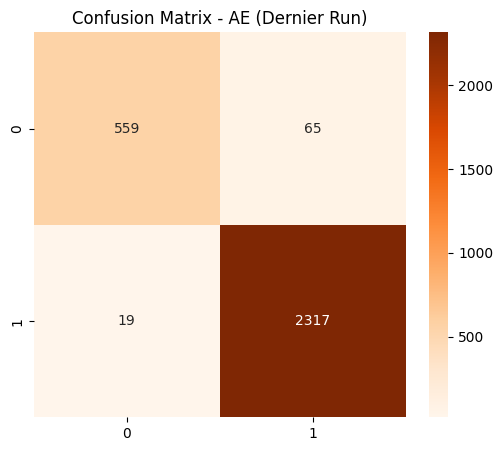

In [25]:
# Visualisation AE
cm_ae = confusion_matrix(y_test, preds_ae['y_pred'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - AE (Dernier Run)")
plt.show()

# 2. Auto-Encodeur Débruiteur (DAE)


In [26]:
print("\n=== 2. Denoising Auto-Encodeur (DAE) ===")
# Note: noise_factor=0.2 est important ici
df_dae, preds_dae = run_ae_protocol(DenoisingAutoencoder, "Denoising AE", n_runs=10, epochs=30, noise_factor=0.2)
mean_dae = df_dae.mean()
std_dae = df_dae.std()

print("Résultats DAE (Moyenne ± Ecart-type) :")
for metric in df_dae.columns:
    print(f"{metric:<15}: {mean_dae[metric]:.4f} ± {std_dae[metric]:.4f}")


=== 2. Denoising Auto-Encodeur (DAE) ===
--- Lancement du protocole pour Denoising AE (10 runs) ---
Run 10/10...
Protocole Denoising AE terminé.
Résultats DAE (Moyenne ± Ecart-type) :
Accuracy       : 0.9739 ± 0.0017
Recall         : 0.9969 ± 0.0024
Precision      : 0.9707 ± 0.0013
F1-Score       : 0.9837 ± 0.0011
ROC-AUC        : 0.9463 ± 0.0026
Time (s)       : 2.1832 ± 0.1064
Memory (MB)    : 0.2092 ± 0.0024


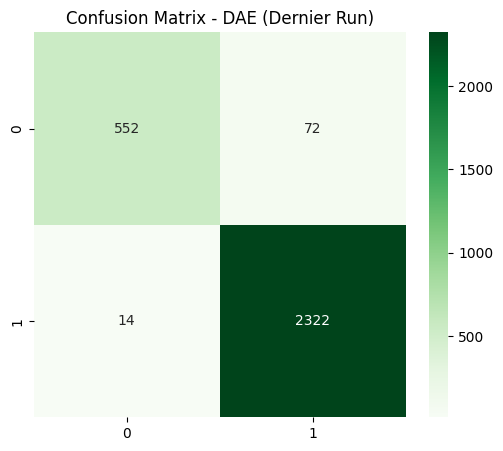

In [27]:
# Visualisation DAE
cm_dae = confusion_matrix(y_test, preds_dae['y_pred'])
plt.figure(figsize=(6,5))
sns.heatmap(cm_dae, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - DAE (Dernier Run)")
plt.show()

# 3. Comparaison Globale

In [28]:
# Comparaison des moyennes
summary = pd.DataFrame({
    'AE Simple': mean_ae,
    'Denoising AE': mean_dae
}).T

print("\n--- Tableau Récapitulatif ---")
print(summary[['Accuracy', 'Recall', 'Precision', 'F1-Score', 'ROC-AUC', 'Time (s)', 'Memory (MB)']].to_markdown(floatfmt=".4f"))


--- Tableau Récapitulatif ---
|              |   Accuracy |   Recall |   Precision |   F1-Score |   ROC-AUC |   Time (s) |   Memory (MB) |
|:-------------|-----------:|---------:|------------:|-----------:|----------:|-----------:|--------------:|
| AE Simple    |     0.9725 |   0.9937 |      0.9720 |     0.9827 |    0.9470 |     2.0709 |        0.2100 |
| Denoising AE |     0.9739 |   0.9969 |      0.9707 |     0.9837 |    0.9463 |     2.1832 |        0.2092 |


In [29]:
# Ces valeurs viennent de votre output 'mean_if' dans le notebook Isolation Forest
results_if_mean = {
    'Accuracy': 0.9545,
    'Recall': 0.9994,
    'Precision': 0.9460,
    'F1-Score': 0.9720,
    'ROC-AUC': 0.9332,
    'Time (s)': 0.8268,
    'Memory (MB)': 1.3038
}


=== COMPARAISON FINALE DES 3 APPROCHES (Moyennes) ===
|                    |   Accuracy |   Recall |   Precision |   F1-Score |   ROC-AUC |   Time (s) |   Memory (MB) |
|:-------------------|-----------:|---------:|------------:|-----------:|----------:|-----------:|--------------:|
| Isolation Forest   |     0.9545 |   0.9994 |      0.9460 |     0.9720 |    0.9332 |     0.8268 |        1.3038 |
| Auto-Encodeur (AE) |     0.9725 |   0.9937 |      0.9720 |     0.9827 |    0.9470 |     2.0709 |        0.2100 |
| Denoising AE (DAE) |     0.9739 |   0.9969 |      0.9707 |     0.9837 |    0.9463 |     2.1832 |        0.2092 |


<Figure size 1000x600 with 0 Axes>

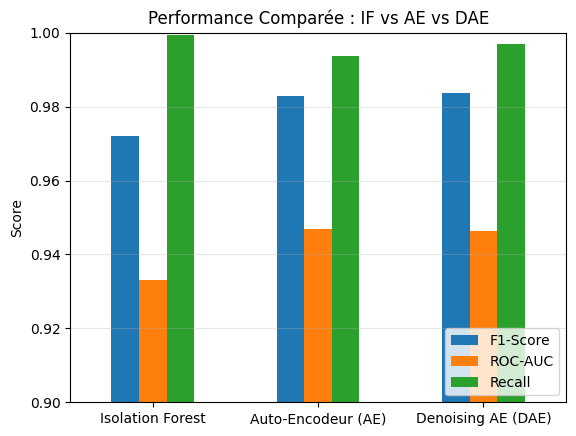

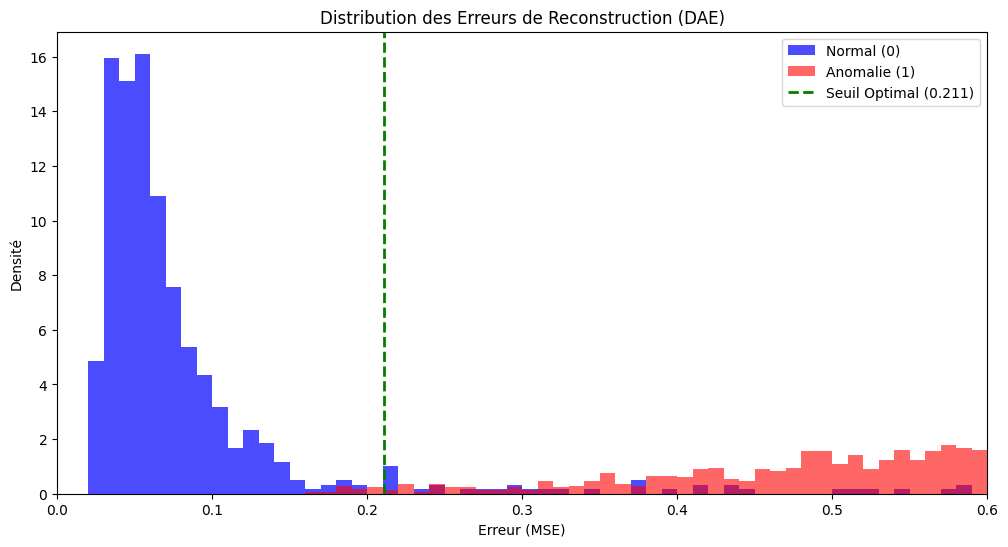

In [30]:
#--- Cellule 7 : Comparaison Finale et Graphiques ---

# 1. Récupération des résultats Isolation Forest (Valeurs manuelles de votre autre notebook)
if_results = {
    'Accuracy': 0.9545,
    'Recall': 0.9994,
    'Precision': 0.9460,
    'F1-Score': 0.9720,
    'ROC-AUC': 0.9332,
    'Time (s)': 0.8268,
    'Memory (MB)': 1.3038
}

# 2. Création du DataFrame Comparatif
df_global = pd.DataFrame({
    'Isolation Forest': if_results,
    'Auto-Encodeur (AE)': mean_ae.to_dict(),
    'Denoising AE (DAE)': mean_dae.to_dict()
}).T

print("\n=== COMPARAISON FINALE DES 3 APPROCHES (Moyennes) ===")
print(df_global.to_markdown(floatfmt=".4f"))

# 3. Graphique de Performance
plt.figure(figsize=(10, 6))
df_global[['F1-Score', 'ROC-AUC', 'Recall']].plot(kind='bar', rot=0, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Performance Comparée : IF vs AE vs DAE")
plt.ylim(0.90, 1.0) 
plt.ylabel("Score")
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='lower right')
plt.show()

# 4. Histogramme des Erreurs (DAE) - Aide à l'interprétation
# Utilise le dernier modèle DAE entraîné
model = preds_dae['model']
threshold = preds_dae['threshold']
model.eval()

# Calcul des erreurs
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))
with torch.no_grad():
    recon = model(X_test_tensor)
    errors = torch.mean((X_test_tensor - recon) ** 2, dim=1).numpy()

# Séparation par classe
errors_normal = errors[y_test == 0]
errors_anomaly = errors[y_test == 1]

plt.figure(figsize=(12, 6))
plt.hist(errors_normal, bins=100, alpha=0.7, label='Normal (0)', color='blue', density=True, range=(0, 1.0))
plt.hist(errors_anomaly, bins=100, alpha=0.6, label='Anomalie (1)', color='red', density=True, range=(0, 1.0))
plt.axvline(threshold, color='green', linestyle='--', linewidth=2, label=f'Seuil Optimal ({threshold:.3f})')

plt.title("Distribution des Erreurs de Reconstruction (DAE)")
plt.xlabel("Erreur (MSE)")
plt.ylabel("Densité")
plt.xlim(0, 0.6) # Zoom
plt.legend()
plt.show()